In [4]:
#Import necessary libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
#Read in track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
#Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json')

In [6]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics,tracks[['track_id','genre_top']],on='track_id')

In [7]:
#Create a correlation matrix to inspect the features with strong correlation and prevent redundancy and overfitting
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


In [8]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [9]:
#No particularly strong correlations, so split the data into training and testing sets

#Create features
features = echo_tracks.drop(['genre_top','track_id'],axis=1).values

#Create labels
labels = echo_tracks['genre_top'].values

#Split into training and testing sets
train_features,test_features,train_labels,test_labels = train_test_split(features,labels,test_size=0.3,random_state=101)

In [10]:
#Create an instance of a StandardScaler
scaler = StandardScaler()

In [11]:
#Scale the train features and test features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [12]:
#Create an instance of PCA to get an explained variance ratio using all the features
pca = PCA()

exp_variance = pca.fit(scaled_train_features).explained_variance_ratio_

Text(0.5, 0, 'Principal Component #')

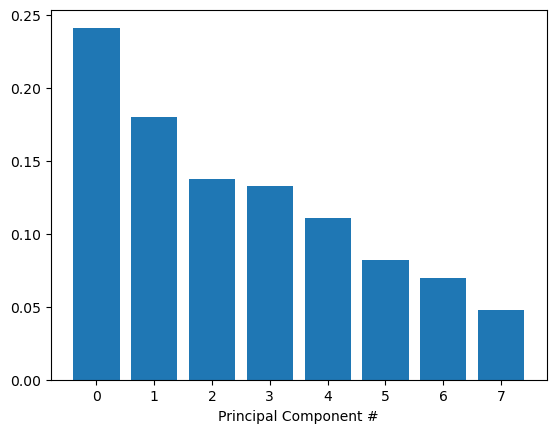

In [13]:
#Create a scree plot to determine the number of components to use for further analyses
fig, ax = plt.subplots()
ax.bar(x=range(pca.n_components_),height=exp_variance)
ax.set_xlabel('Principal Component #')

In [14]:
# No steep drop for the scree plot, so let's use a cumulative explained variance plot to find the number of componentd to explain about 85% of the variance
cum_exp_variance = np.cumsum(exp_variance)

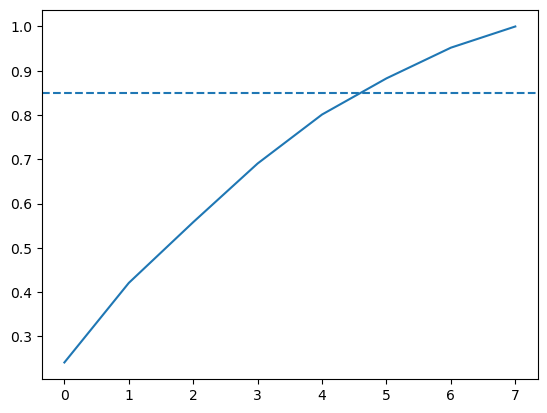

In [15]:
# Plot the cumulative explained variance and draw a dashed line at 0.85 to get enough information that accounts for 85% variance.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [86]:
#From the new plot, 6 features can explain 85% of the variance

#Perfom PCA with the 6 components
pca = PCA(n_components=6,random_state=101)

In [87]:
# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

In [88]:
#Create a DecisionTreeClassifier object to classify songs into genres
tree = DecisionTreeClassifier(random_state=101)

In [89]:
#Train the decision tree model
tree.fit(train_pca,train_labels)

DecisionTreeClassifier(random_state=101)

In [90]:
#Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

In [92]:
# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=101)
logreg.fit(train_pca,train_labels)

pred_labels_logit = logreg.predict(test_pca)

# Create the classification report for both models and check them out
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.61      0.68      0.64       271
        Rock       0.92      0.90      0.91      1170

    accuracy                           0.86      1441
   macro avg       0.77      0.79      0.78      1441
weighted avg       0.86      0.86      0.86      1441

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.56      0.65       271
        Rock       0.90      0.96      0.93      1170

    accuracy                           0.88      1441
   macro avg       0.83      0.76      0.79      1441
weighted avg       0.88      0.88      0.88      1441



In [136]:
#We need to balance the data because from the report, Hip-Hop does poorly and most of the model's accuracy is based on Rock and not on Hip-Hop due to tghe extreme difference in points.
#We can weigh the correct classification in each class inversely to the occurence of data points for each class

#Get only the hip-hop tracks
hop_only = echo_tracks[echo_tracks['genre_top'] == 'Hip-Hop']

#Get only the rock tracks
rock_only = echo_tracks[echo_tracks['genre_top'] == 'Rock']

#Sample the rock_only dataframe to be the same number as the hop_only dataframe
rock_only = rock_only.sample(n=len(hop_only),random_state=101)

#Concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

In [137]:
# Recreate the features and labels for the new balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Recreate the train and test set from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(features,labels,test_size=0.3,random_state=101)

# Recreate the pca_projection from the balanced data
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

In [139]:
#Now let's try using the decision tree and logisitic regression models on the balanced data to see if balancing the data improved model bias

# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=101)
tree.fit(train_pca,train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=101)
logreg.fit(train_pca,train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.73      0.78      0.76       267
        Rock       0.78      0.73      0.75       279

    accuracy                           0.75       546
   macro avg       0.76      0.76      0.75       546
weighted avg       0.76      0.75      0.75       546

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.81      0.81       267
        Rock       0.82      0.81      0.81       279

    accuracy                           0.81       546
   macro avg       0.81      0.81      0.81       546
weighted avg       0.81      0.81      0.81       546



In [142]:
#Our balanced data has removed bias towards the rock class. We can use cross-validation to get a good sense of how well our models are actually performing.

#Use a pipeline for scaling,PCA and model selection
tree_pipe = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=6)),
                     ('tree',DecisionTreeClassifier(random_state=101))])
logreg_pipe = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=6)),
                     ('logreg',LogisticRegression(random_state=101))])

In [147]:
# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

# Train our models using KFold cv on the balanced datasets
tree_score = cross_val_score(tree_pipe,X=features,y=labels,cv=kf)
logit_score = cross_val_score(logreg_pipe,X=features,y=labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "\nLogistic Regression:", np.mean(logit_score))

Decision Tree: 0.7351648351648351 
Logistic Regression: 0.7807692307692307
